# 🔍 DWSIM Shower Example

**Created by: Prof. Nicolas Spogis, Ph.D.**  
Phone/WhatsApp: +55 (19) 99844-0460  
Email: nicolas.spogis@gmail.com | nicolas.spogis@ai4tech.ai  
LinkTree: [https://linktr.ee/Ai4Tech](https://linktr.ee/Ai4Tech)


In [1]:
# remove the following two lines to run on linux
import pythoncom
pythoncom.CoInitialize()

from opyrability import multimodel_rep, OI_eval
import numpy as np
import matplotlib.pyplot as plt

In [2]:
########################################################################################################################
# Call DWSIM DLLs
########################################################################################################################
import clr

# Change your DWSIM installation path

In [3]:
dwsimpath = "C:\\Users\\nicol\\AppData\\Local\\DWSIM\\" 

In [4]:
clr.AddReference(dwsimpath + "\\CapeOpen.dll")
clr.AddReference(dwsimpath + "\\DWSIM.Automation.dll")
clr.AddReference(dwsimpath + "\\DWSIM.Interfaces.dll")
clr.AddReference(dwsimpath + "\\DWSIM.GlobalSettings.dll")
clr.AddReference(dwsimpath + "\\DWSIM.SharedClasses.dll")
clr.AddReference(dwsimpath + "\\DWSIM.Thermodynamics.dll")
clr.AddReference(dwsimpath + "\\DWSIM.UnitOperations.dll")
clr.AddReference(dwsimpath + "\\DWSIM.Inspector.dll")
clr.AddReference(dwsimpath + "\\System.Buffers.dll")
clr.AddReference(dwsimpath + "\\DWSIM.Thermodynamics.ThermoC.dll")

In [5]:
########################################################################################################################
# Open DWSIM Automation
########################################################################################################################
def open_DWSIM(dwsimpath, FlowsheetFile):
    from DWSIM.Automation import Automation3
    manager = Automation3()
    myflowsheet = manager.LoadFlowsheet(FlowsheetFile)
    return manager, myflowsheet

In [6]:
########################################################################################################################
# Open DWSIM Automation
########################################################################################################################
FlowsheetFile = "Shower.dwxmz"
manager, myflowsheet = open_DWSIM(dwsimpath, FlowsheetFile)

In [7]:
########################################################################################################################
# Call DWSIM -> Change Input Parameters -> Solve - Get Output Parameters
########################################################################################################################
def opyrability_model(AIS):
    global manager, myflowsheet
    # Set Input Parameter
    obj = myflowsheet.GetFlowsheetSimulationObject('Hot Water')
    feed = obj.GetAsObject()
    feed.SetVolumetricFlow(AIS[0] / 3600)  #m3/s

    obj = myflowsheet.GetFlowsheetSimulationObject('Cold Water')
    feed = obj.GetAsObject()
    feed.SetVolumetricFlow(AIS[1] / 3600)  # m3/s

    # Request a calculation
    errors = manager.CalculateFlowsheet4(myflowsheet)

    obj = myflowsheet.GetFlowsheetSimulationObject('Shower')
    feed = obj.GetAsObject()
    temperature = feed.GetTemperature() - 273.15        #Celcius
    volumetric_flow = feed.GetVolumetricFlow() * 3600   #m3/h

    result = np.array([volumetric_flow, temperature])
    return result

In [8]:
########################################################################################################################
# Run One Case to Test
########################################################################################################################
results = opyrability_model([1,5])
print(f"Volumetric Flow = {results[0]:.2f} m3/h")
print(f"Temperature = {results[0]:.2f} Celcius")

Volumetric Flow = 5.99 m3/h
Temperature = 5.99 Celcius


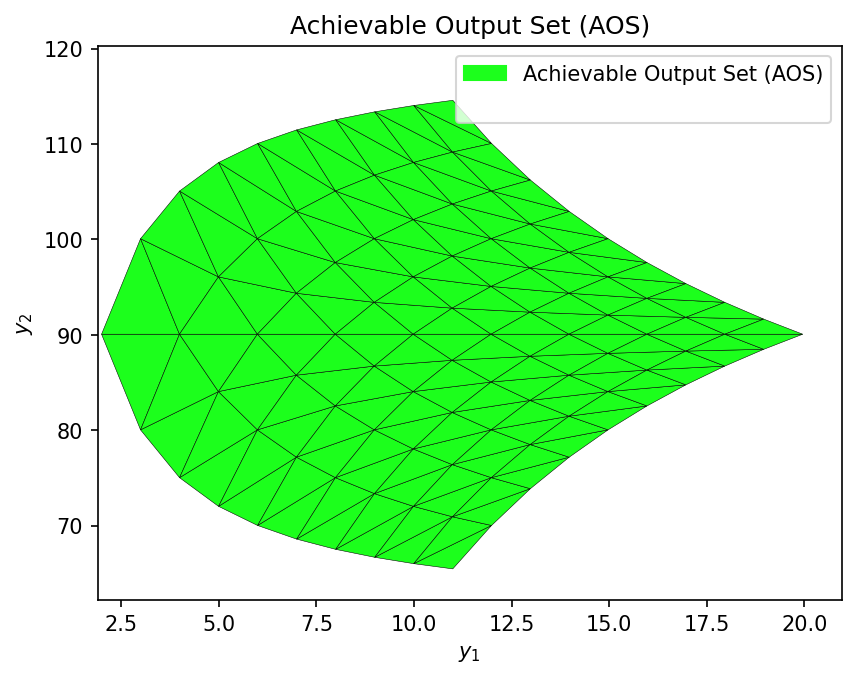

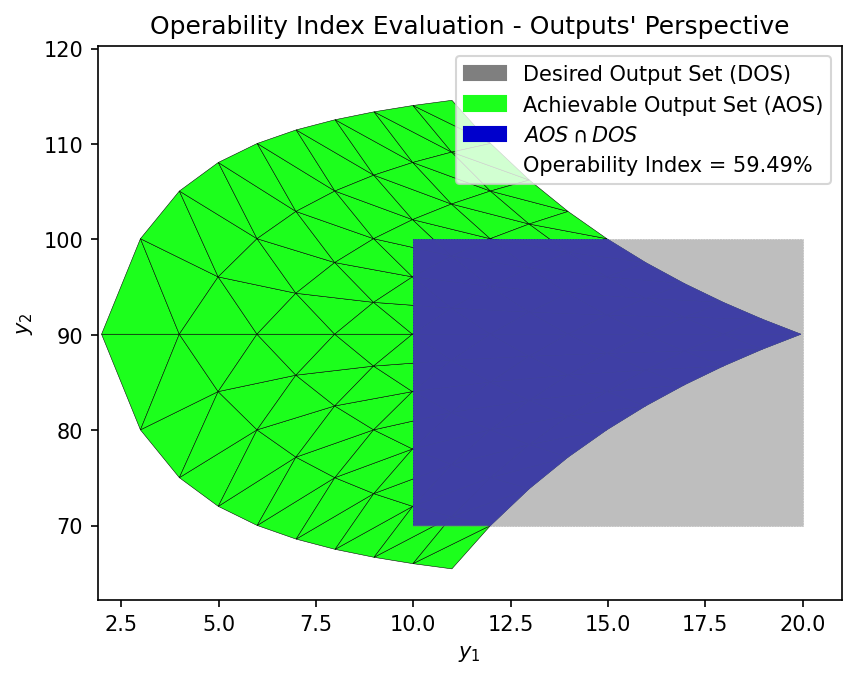

In [9]:
########################################################################################################################
# Defining the AIS and DOS Bounds and Run Multimodel
########################################################################################################################
DOS_bounds =  np.array([[10, 20],
                        [70, 100]])

AIS_bounds =  np.array([[1, 10],
                        [1, 10]])

AIS_resolution =  [10, 10]

AOS_region = multimodel_rep(opyrability_model, AIS_bounds, AIS_resolution, plot=True)

OI = OI_eval(AOS_region, DOS_bounds, plot=True)

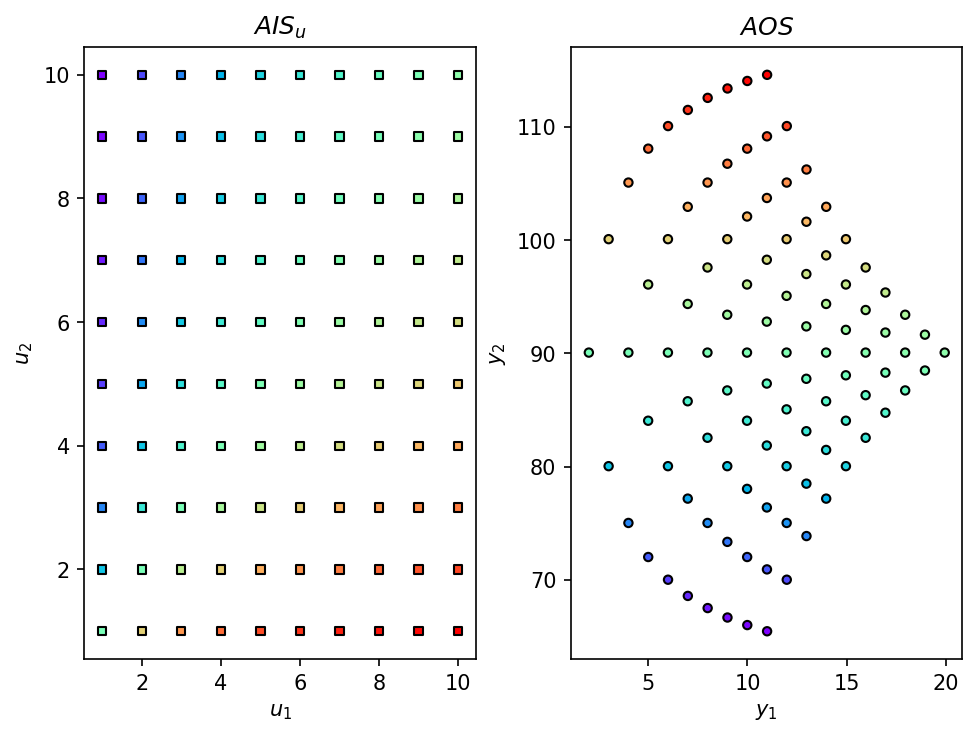

In [10]:
########################################################################################################################
# Obtain discretized AIS/AOS
########################################################################################################################
from opyrability import AIS2AOS_map
AIS, AOS = AIS2AOS_map(opyrability_model, AIS_bounds, AIS_resolution, plot=True)

plt.savefig('AIS2AOS_map.png')
plt.show()
plt.close()

100%|██████████| 100/100 [00:05<00:00, 17.87it/s]


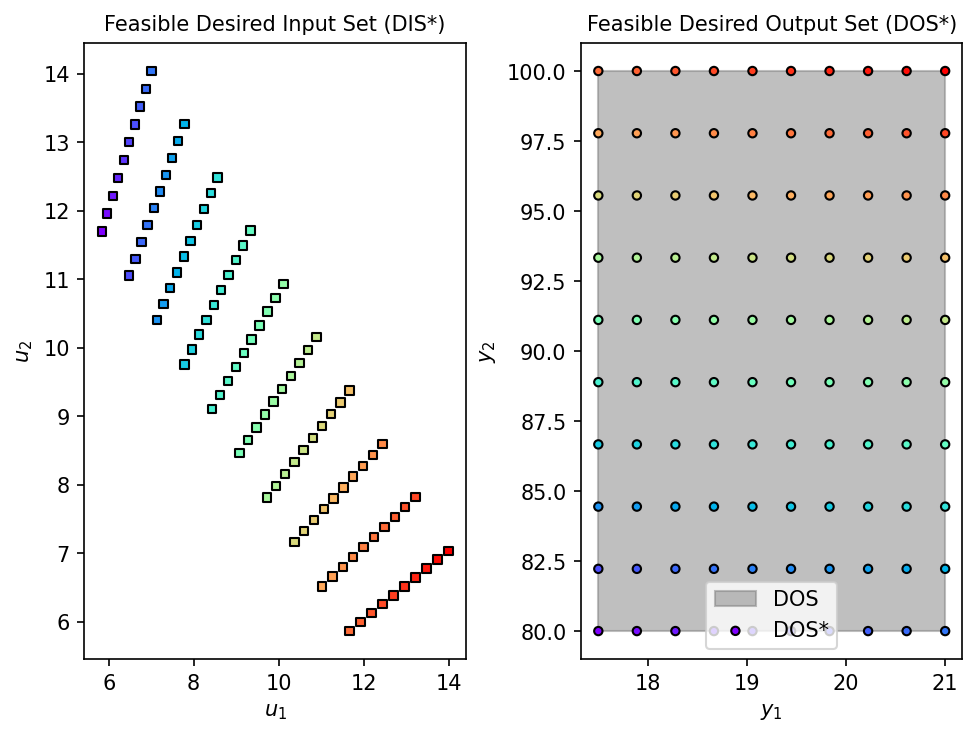

In [11]:
########################################################################################################################
# Inverse Mapping
########################################################################################################################
from opyrability import nlp_based_approach

# Initial estimate for the inverse mapping at each point.
# Should have same dimension as model inputs.
u0 = np.array([0, 10])

# Lower bound on inputs.
lb = np.array([0, 0])

# Upper bound on inputs.
ub = np.array([100,100])

# Array containing the bounds of the Desired Output set (DOS).
# Each row corresponds to the lower and upper bound of each variable.
DOS_bounds = np.array([[17.5, 21.0],
                       [80.0, 100.0]])

DOS_resolution = [10, 10]

# Obtaining inverse map of the Shower design
fDIS, fDOS, message = nlp_based_approach(opyrability_model,
                                        DOS_bounds,
                                        DOS_resolution,
                                        u0,
                                        lb,
                                        ub,
                                        method='ipopt',
                                        plot=True,
                                        ad=False,
                                        warmstart=True)

plt.savefig('Inverse_Map.png')
plt.show()
plt.close()